# 1- Import Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 2- Data Processing

In [11]:
# Load the data (assuming u.data is in MovieLens format)
columns = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=columns)

print(data.head())
print("=========================================")
print(data.shape)
print("=========================================")
print(data.info())
print("=========================================")

# Create user-item matrix
user_item_matrix = data.pivot_table(index='user_id', columns='item_id', values='rating')

# Normalize ratings by subtracting user mean
user_mean_ratings = user_item_matrix.mean(axis=1)
user_item_normalized = user_item_matrix.sub(user_mean_ratings, axis=0)

# Fill missing values with 0 (neutral rating after normalization)
user_item_normalized = user_item_normalized.fillna(0)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
(100000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None


# 3- Exploratory Data Visualization

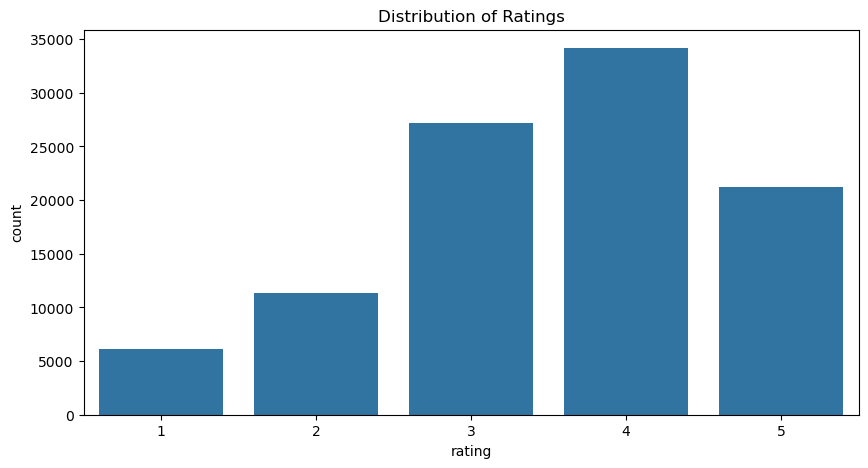

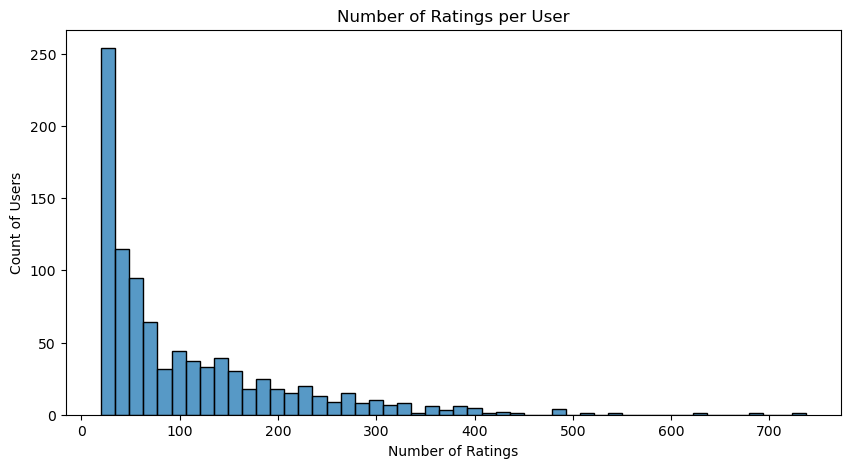

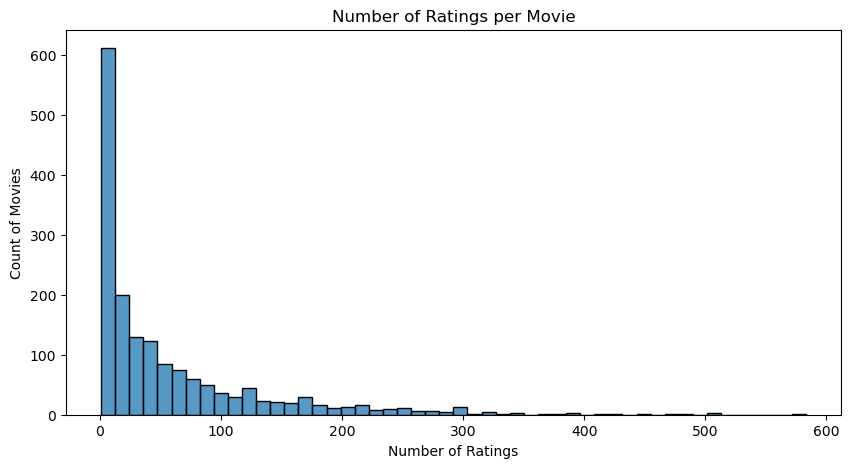

In [14]:
# Rating distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', data=data)
plt.title('Distribution of Ratings')
plt.show()

# Number of ratings per user
user_rating_counts = data['user_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

# Number of ratings per movie
movie_rating_counts = data['item_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(movie_rating_counts, bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()

# 4- Modeling - User-Based Collaborative Filtering

In [29]:
def recommend_movies(user_id, user_item_matrix, n_recommendations=5, min_similarity=0.1):
    """
    movie recommendation based on user similarity
    - Only considers positive similarities
    - Uses mean-centered ratings
    - Adds minimum similarity threshold
    - Better handling of unrated movies
    """
    # Normalize by user mean (mean-centered cosine similarity)
    user_mean_ratings = user_item_matrix.mean(axis=1)
    user_item_normalized = user_item_matrix.sub(user_mean_ratings, axis=0).fillna(0)
    
    # Compute user-user similarity
    user_similarity = cosine_similarity(user_item_normalized)
    user_similarity_df = pd.DataFrame(user_similarity,
                                    index=user_item_matrix.index,
                                    columns=user_item_matrix.index)
    
    # Get similar users (positive similarity only)
    similar_users = user_similarity_df[user_id][(user_similarity_df[user_id] > min_similarity) & 
                                              (user_similarity_df.index != user_id)]
    
    if len(similar_users) == 0:
        return pd.Series([], dtype=float)  # Return empty if no similar users
    
    # Get movies the target user hasn't rated
    target_rated = user_item_matrix.loc[user_id].dropna().index
    all_movies = user_item_matrix.columns
    unrated_movies = [m for m in all_movies if m not in target_rated]
    
    # Calculate predicted ratings
    movie_scores = pd.Series(0.0, index=unrated_movies)
    total_similarity = 0.0
    
    for other_user, similarity in similar_users.items():
        other_ratings = user_item_matrix.loc[other_user, unrated_movies]
        valid_ratings = other_ratings.dropna()
        movie_scores[valid_ratings.index] += valid_ratings * similarity
        total_similarity += similarity
    
    if total_similarity > 0:
        movie_scores = movie_scores / total_similarity
    
    return movie_scores.nlargest(n_recommendations)

# 5- Evaluation - Precision at K

In [31]:
def precision_at_k(user_id, test_ratings, recommendations, k=5, rating_threshold=4):
    """
     precision calculation
    - Better handling of cases with fewer than K recommendations
    - Explicit rating threshold parameter
    - More robust intersection calculation
    """
    if len(recommendations) == 0:
        return 0.0  # If no recommendations, precision is 0
    
    # Get top K recommendations (or all if fewer than K)
    top_k = recommendations.index[:min(k, len(recommendations))]
    
    # Get movies the user actually liked in test set
    user_test_ratings = test_ratings[(test_ratings['user_id'] == user_id)]
    liked_movies = set(user_test_ratings[user_test_ratings['rating'] >= rating_threshold]['item_id'])
    
    # Calculate hits
    hits = len(set(top_k) & liked_movies)
    
    return hits / len(top_k)  # Normalize by actual K

# Example usage
if __name__ == "__main__":
    # Load data
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('u.data', sep='\t', names=columns)
    test_data = pd.read_csv('ua.test', sep='\t', names=columns)
    
    # Create user-item matrix
    user_item_matrix = data.pivot_table(index='user_id', columns='item_id', values='rating')
    
    # Test with user 1
    user_id = 1
    recommendations = recommend_movies(user_id, user_item_matrix)
    
    if len(recommendations) > 0:
        precision = precision_at_k(user_id, test_data, recommendations)
        print(f"Precision at 5 for user {user_id}: {precision:.2f}")
        print("Top recommendations:")
        print(recommendations)
    else:
        print(f"No recommendations could be made for user {user_id}")

Precision at 5 for user 1: 0.00
Top recommendations:
318    2.437926
423    2.358528
357    2.175668
568    2.173833
405    2.117732
dtype: float64


# 6- Post-Modeling Visualization

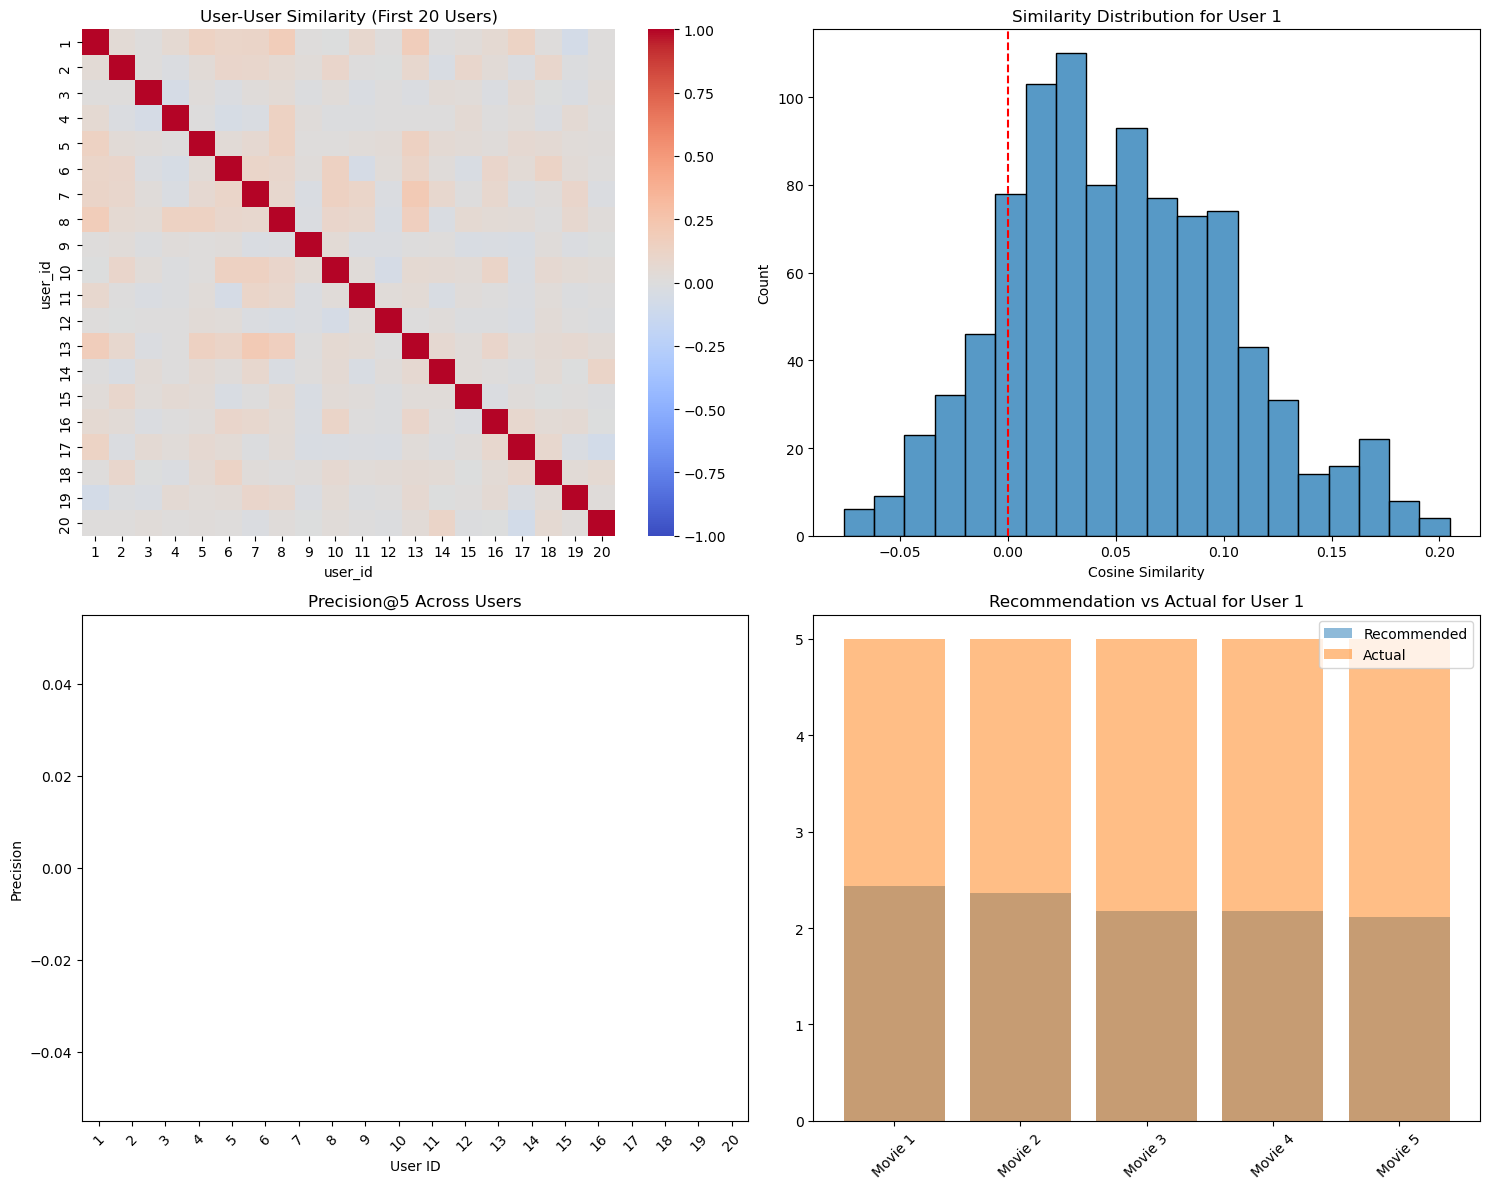

In [35]:
def post_modeling_visualizations(user_item_matrix, recommendations, test_data, target_user_id=1, n_users=20):
    """
    Generate visualizations after modeling with proper variable definitions
    Includes:
    - User similarity heatmap
    - Recommendation performance
    - User rating distribution comparison
    """
    # First we need to compute the similarity matrix properly
    user_mean_ratings = user_item_matrix.mean(axis=1)
    user_item_normalized = user_item_matrix.sub(user_mean_ratings, axis=0).fillna(0)
    user_similarity = cosine_similarity(user_item_normalized)
    user_similarity_df = pd.DataFrame(user_similarity,
                                    index=user_item_matrix.index,
                                    columns=user_item_matrix.index)
    
    plt.figure(figsize=(15, 12))
    
    # 1. User similarity heatmap (for first n_users)
    plt.subplot(2, 2, 1)
    sns.heatmap(user_similarity_df.iloc[:n_users, :n_users], cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'User-User Similarity (First {n_users} Users)')
    
    # 2. Target user's similarity distribution
    plt.subplot(2, 2, 2)
    target_similarities = user_similarity_df[target_user_id].sort_values(ascending=False)[1:]  # exclude self
    sns.histplot(target_similarities, bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Similarity Distribution for User {target_user_id}')
    plt.xlabel('Cosine Similarity')
    
    # 3. Precision at K across sample users
    plt.subplot(2, 2, 3)
    sample_users = user_item_matrix.index[:n_users]
    precisions = []
    for u in sample_users:
        user_recs = recommend_movies(u, user_item_matrix)
        precisions.append(precision_at_k(u, test_data, user_recs))
    
    sns.barplot(x=sample_users, y=precisions)
    plt.title(f'Precision@5 Across Users')
    plt.xlabel('User ID')
    plt.ylabel('Precision')
    plt.xticks(rotation=45)
    
    # 4. Recommended vs Actual Top Movies for target user
    if target_user_id in user_item_matrix.index and len(recommendations) > 0:
        plt.subplot(2, 2, 4)
        # Get actual top-rated movies from base set
        target_ratings = user_item_matrix.loc[target_user_id].dropna()
        actual_top = target_ratings.nlargest(5)
        
        # Create comparison data
        comparison = pd.DataFrame({
            'Recommended': recommendations.index[:5],
            'Recommended Score': recommendations.values[:5],
            'Actual Top': actual_top.index,
            'Actual Rating': actual_top.values
        })
        
        # Plot comparison
        plt.bar(range(5), comparison['Recommended Score'], alpha=0.5, label='Recommended')
        plt.bar(range(5), comparison['Actual Rating'], alpha=0.5, label='Actual')
        plt.xticks(range(5), [f'Movie {i+1}' for i in range(5)], rotation=45)
        plt.title(f'Recommendation vs Actual for User {target_user_id}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage with our previous variables
if __name__ == "__main__":
    # Load data (same as before)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('u.data', sep='\t', names=columns)
    test_data = pd.read_csv('ua.test', sep='\t', names=columns)
    
    # Create user-item matrix
    user_item_matrix = data.pivot_table(index='user_id', columns='item_id', values='rating')
    
    # Get recommendations for user 1
    user_id = 1
    recommendations = recommend_movies(user_id, user_item_matrix)
    
    # Generate visualizations
    post_modeling_visualizations(user_item_matrix, recommendations, test_data, target_user_id=user_id)

# GUI


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_23128\4219416265.py", line 129, in generate_recommendations
    self.recommendations = self.recommend_movies(
                           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_23128\4219416265.py", line 144, in recommend_movies
    similar_users = self.user_similarity_df[user_id][
                    ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^
TypeError: 'NoneType' object is not subscriptable
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_23128\4219416265.py", line 129, in generate_recommendations
    self.recom

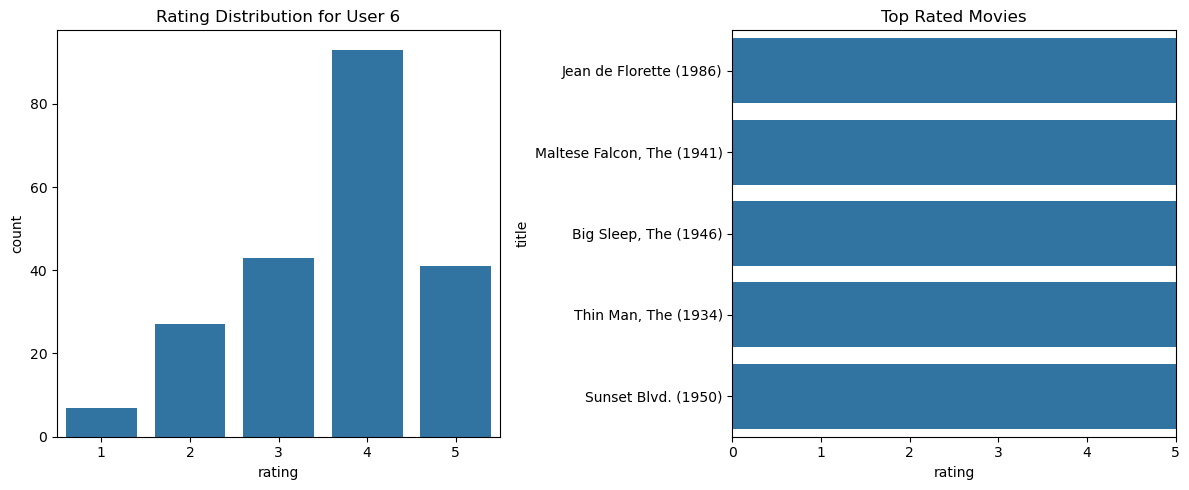

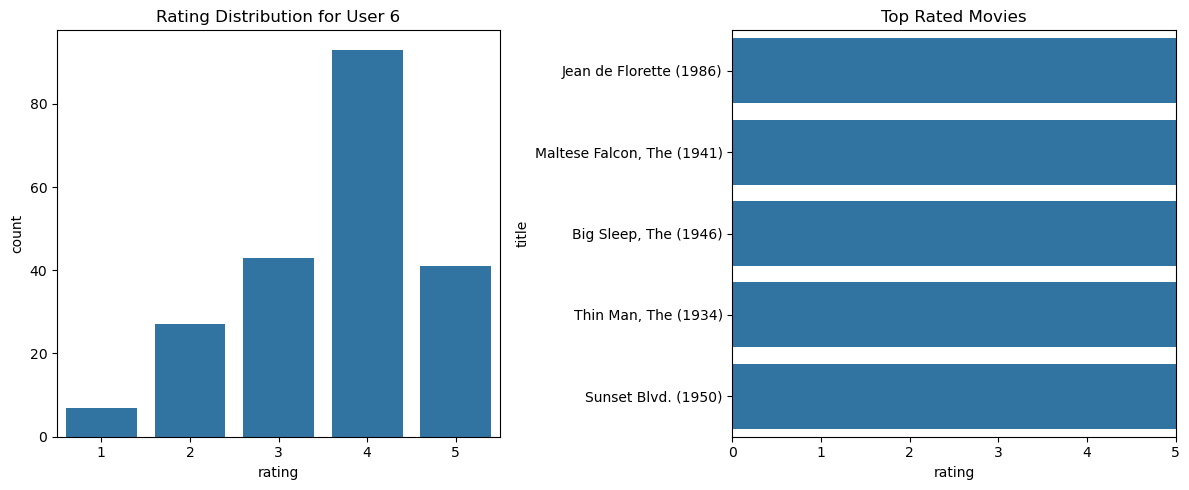

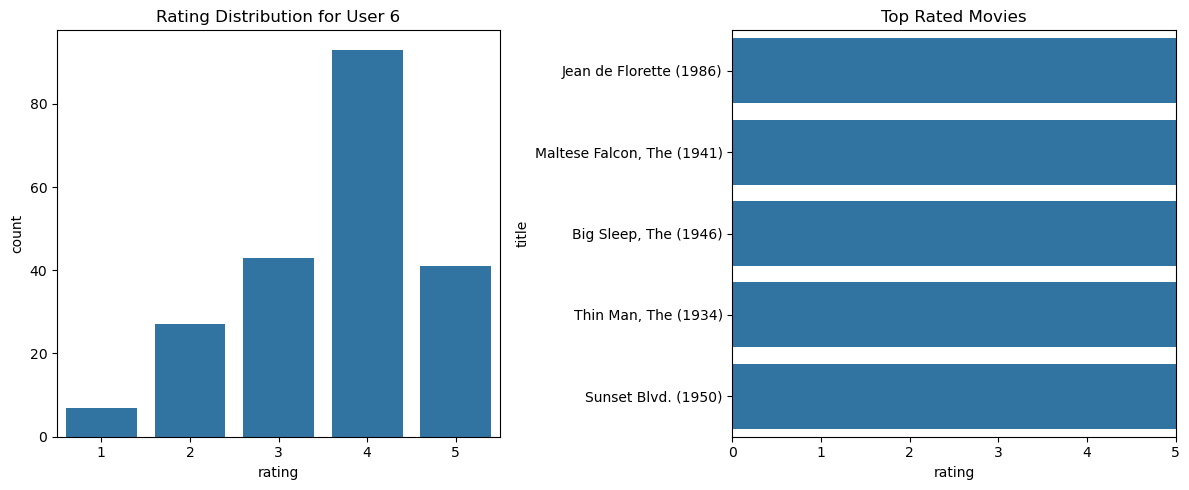

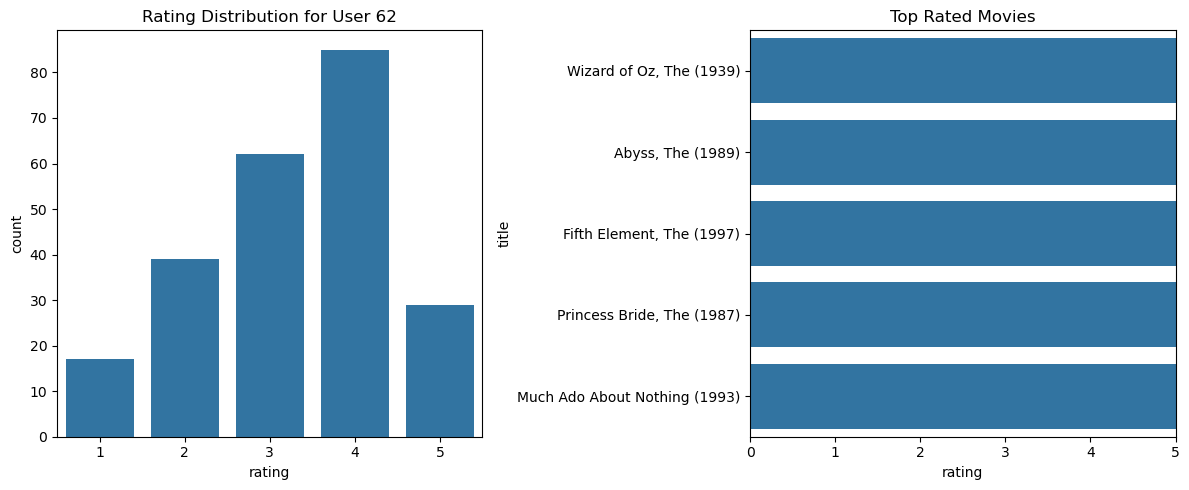

In [37]:
import tkinter as tk
from tkinter import ttk, messagebox
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class MovieRecommenderApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Movie Recommendation System")
        self.root.geometry("1200x800")
        
        # Load data
        self.load_data()
        
        # Create GUI elements
        self.create_widgets()
        
        # Initialize variables
        self.user_item_matrix = None
        self.user_similarity_df = None
        self.recommendations = None
        
    def load_data(self):
        """Load the movie data and ratings"""
        try:
            # Load ratings data
            self.ratings = pd.read_csv('u.data', sep='\t', 
                                      names=['user_id', 'item_id', 'rating', 'timestamp'])
            
            # Load movie data (assuming u.item exists in MovieLens format)
            self.movies = pd.read_csv('u.item', sep='|', encoding='latin-1',
                                    names=['item_id', 'title', 'release_date', 'video_release_date',
                                          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                                          'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                                          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
            
            # Create user-item matrix
            self.user_item_matrix = self.ratings.pivot_table(
                index='user_id', columns='item_id', values='rating')
            
            # Compute similarities
            self.compute_similarities()
            
        except FileNotFoundError:
            messagebox.showerror("Error", "Data files not found. Please ensure u.data and u.item are in the same directory.")
            self.root.destroy()
    
    def compute_similarities(self):
        """Compute user-user similarities"""
        user_mean_ratings = self.user_item_matrix.mean(axis=1)
        user_item_normalized = self.user_item_matrix.sub(user_mean_ratings, axis=0).fillna(0)
        user_similarity = cosine_similarity(user_item_normalized)
        self.user_similarity_df = pd.DataFrame(
            user_similarity,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )
    
    def create_widgets(self):
        """Create all GUI widgets"""
        # Main container
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Left panel - Controls
        control_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=5, pady=5)
        
        # User selection
        ttk.Label(control_frame, text="Select User:").pack(pady=(0, 5))
        self.user_var = tk.StringVar()
        self.user_combobox = ttk.Combobox(control_frame, textvariable=self.user_var)
        self.user_combobox.pack(fill=tk.X, pady=(0, 10))
        self.user_combobox['values'] = sorted(self.user_item_matrix.index.unique())
        self.user_combobox.bind("<<ComboboxSelected>>", self.on_user_select)
        
        # Recommendation settings
        ttk.Label(control_frame, text="Number of Recommendations:").pack(pady=(0, 5))
        self.num_rec_var = tk.IntVar(value=5)
        ttk.Spinbox(control_frame, from_=1, to=20, textvariable=self.num_rec_var).pack(fill=tk.X, pady=(0, 10))
        
        # Similarity threshold
        ttk.Label(control_frame, text="Minimum Similarity:").pack(pady=(0, 5))
        self.sim_thresh_var = tk.DoubleVar(value=0.1)
        ttk.Scale(control_frame, from_=0, to=1, variable=self.sim_thresh_var, 
                 orient=tk.HORIZONTAL).pack(fill=tk.X, pady=(0, 10))
        
        # Action buttons
        ttk.Button(control_frame, text="Generate Recommendations", 
                  command=self.generate_recommendations).pack(pady=10)
        ttk.Button(control_frame, text="Show User Stats", 
                  command=self.show_user_stats).pack(pady=5)
        ttk.Button(control_frame, text="Show System Metrics", 
                  command=self.show_system_metrics).pack(pady=5)
        
        # Right panel - Results
        result_frame = ttk.LabelFrame(main_frame, text="Results", padding="10")
        result_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # Recommendation results
        self.result_text = tk.Text(result_frame, wrap=tk.WORD)
        self.result_text.pack(fill=tk.BOTH, expand=True)
        
        # Visualization frame
        self.viz_frame = ttk.Frame(result_frame)
        self.viz_frame.pack(fill=tk.BOTH, expand=True)
    
    def on_user_select(self, event=None):
        """When user is selected, show basic info"""
        user_id = int(self.user_var.get())
        ratings_count = self.ratings[self.ratings['user_id'] == user_id].shape[0]
        avg_rating = self.ratings[self.ratings['user_id'] == user_id]['rating'].mean()
        
        self.result_text.delete(1.0, tk.END)
        self.result_text.insert(tk.END, 
                              f"User {user_id} Stats:\n"
                              f"Number of ratings: {ratings_count}\n"
                              f"Average rating: {avg_rating:.2f}\n\n")
    
    def generate_recommendations(self):
        """Generate movie recommendations for selected user"""
        try:
            user_id = int(self.user_var.get())
            n_rec = self.num_rec_var.get()
            min_sim = self.sim_thresh_var.get()
            
            # Get recommendations
            self.recommendations = self.recommend_movies(
                user_id, self.user_item_matrix, n_rec, min_sim)
            
            # Display results
            self.display_recommendations(user_id)
            
            # Show visualizations
            self.show_recommendation_viz(user_id)
            
        except ValueError:
            messagebox.showerror("Error", "Please select a valid user")
    
    def recommend_movies(self, user_id, user_item_matrix, n_recommendations=5, min_similarity=0.1):
        """Improved recommendation function"""
        # Get similar users (positive similarity only)
        similar_users = self.user_similarity_df[user_id][
            (self.user_similarity_df[user_id] > min_similarity) & 
            (self.user_similarity_df.index != user_id)]
        
        if len(similar_users) == 0:
            return pd.Series([], dtype=float)  # Return empty if no similar users
        
        # Get movies the target user hasn't rated
        target_rated = user_item_matrix.loc[user_id].dropna().index
        all_movies = user_item_matrix.columns
        unrated_movies = [m for m in all_movies if m not in target_rated]
        
        # Calculate predicted ratings
        movie_scores = pd.Series(0.0, index=unrated_movies)
        total_similarity = 0.0
        
        for other_user, similarity in similar_users.items():
            other_ratings = user_item_matrix.loc[other_user, unrated_movies]
            valid_ratings = other_ratings.dropna()
            movie_scores[valid_ratings.index] += valid_ratings * similarity
            total_similarity += similarity
        
        if total_similarity > 0:
            movie_scores = movie_scores / total_similarity
        
        return movie_scores.nlargest(n_recommendations)
    
    def display_recommendations(self, user_id):
        """Display recommendations in the text box"""
        self.result_text.delete(1.0, tk.END)
        
        if len(self.recommendations) == 0:
            self.result_text.insert(tk.END, 
                                  f"No recommendations could be made for user {user_id}\n"
                                  "Try lowering the minimum similarity threshold.")
            return
        
        self.result_text.insert(tk.END, f"Top {len(self.recommendations)} Recommendations for User {user_id}:\n\n")
        
        for i, (movie_id, score) in enumerate(self.recommendations.items(), 1):
            movie_info = self.movies[self.movies['item_id'] == movie_id]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
                self.result_text.insert(tk.END, f"{i}. {title} (ID: {movie_id}, Score: {score:.2f})\n")
            else:
                self.result_text.insert(tk.END, f"{i}. Movie ID: {movie_id} (Score: {score:.2f})\n")
    
    def show_recommendation_viz(self, user_id):
        """Show visualizations for recommendations"""
        # Clear previous visualizations
        for widget in self.viz_frame.winfo_children():
            widget.destroy()
        
        if len(self.recommendations) == 0:
            return
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Similarity distribution
        target_similarities = self.user_similarity_df[user_id].sort_values(ascending=False)[1:]
        sns.histplot(target_similarities, bins=20, ax=axes[0])
        axes[0].axvline(x=self.sim_thresh_var.get(), color='r', linestyle='--')
        axes[0].set_title(f'Similarity Distribution for User {user_id}')
        axes[0].set_xlabel('Cosine Similarity')
        
        # Plot 2: Recommendation scores
        rec_df = pd.DataFrame({
            'Movie': [self.movies[self.movies['item_id'] == mid]['title'].values[0] 
                     if not self.movies[self.movies['item_id'] == mid].empty else str(mid)
                     for mid in self.recommendations.index],
            'Score': self.recommendations.values
        })
        sns.barplot(x='Score', y='Movie', data=rec_df, ax=axes[1])
        axes[1].set_title('Recommendation Scores')
        axes[1].set_xlim(0, 5)
        
        plt.tight_layout()
        
        # Embed plot in Tkinter
        canvas = FigureCanvasTkAgg(fig, master=self.viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    def show_user_stats(self):
        """Show detailed statistics for selected user"""
        try:
            user_id = int(self.user_var.get())
            
            # Get user ratings
            user_ratings = self.ratings[self.ratings['user_id'] == user_id]
            
            # Create figure
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Plot 1: Rating distribution
            sns.countplot(x='rating', data=user_ratings, ax=axes[0])
            axes[0].set_title(f'Rating Distribution for User {user_id}')
            
            # Plot 2: Top rated movies
            top_movies = user_ratings.sort_values('rating', ascending=False).head(5)
            top_movies = top_movies.merge(self.movies, on='item_id')
            sns.barplot(x='rating', y='title', data=top_movies, ax=axes[1])
            axes[1].set_title('Top Rated Movies')
            axes[1].set_xlim(0, 5)
            
            plt.tight_layout()
            
            # Show in new window
            self.show_figure_in_window(fig, f"User {user_id} Statistics")
            
        except ValueError:
            messagebox.showerror("Error", "Please select a valid user")
    
    def show_system_metrics(self):
        """Show overall system metrics"""
        # Sample 20 users for performance metrics
        sample_users = sorted(self.user_item_matrix.index.unique())[:20]
        precisions = []
        
        for user_id in sample_users:
            recommendations = self.recommend_movies(
                user_id, self.user_item_matrix, 
                self.num_rec_var.get(), 
                self.sim_thresh_var.get())
            
            # Calculate precision (using training data as proxy for test data)
            if len(recommendations) > 0:
                user_ratings = self.ratings[self.ratings['user_id'] == user_id]
                liked_movies = set(user_ratings[user_ratings['rating'] >= 4]['item_id'])
                hits = len(set(recommendations.index) & liked_movies)
                precisions.append(hits / len(recommendations))
            else:
                precisions.append(0)
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Precision across users
        sns.barplot(x=sample_users, y=precisions, ax=axes[0])
        axes[0].set_title('Precision@K Across Users')
        axes[0].set_xlabel('User ID')
        axes[0].set_ylabel('Precision')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Plot 2: Overall rating distribution
        sns.countplot(x='rating', data=self.ratings, ax=axes[1])
        axes[1].set_title('Overall Rating Distribution')
        
        plt.tight_layout()
        
        # Show in new window
        self.show_figure_in_window(fig, "System Metrics")
    
    def show_figure_in_window(self, fig, title):
        """Display a matplotlib figure in a new window"""
        new_window = tk.Toplevel(self.root)
        new_window.title(title)
        
        canvas = FigureCanvasTkAgg(fig, master=new_window)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Add close button
        close_button = ttk.Button(new_window, text="Close", 
                                command=new_window.destroy)
        close_button.pack(pady=10)

if __name__ == "__main__":
    root = tk.Tk()
    app = MovieRecommenderApp(root)
    root.mainloop()